In [1]:
# For Google Colab
%pip install jaxtyping
%pip install equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 3.4 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random as jrandom
import jax

from jax import config
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Optional
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

jax.enable_checks = True

jax.devices()

[gpu(id=0)]

# Model Definition

In [3]:
class EuropeanPayoff:
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


In [4]:
jnp.ones(100).shape

(100,)

In [127]:
@dataclass
class Range:
    min: float = 0.0
    max: float = 1.0

class HestonSet(eqx.Module):

    n_states: int
    initial_spot_prices: Float[Array, " n"] # Array of initial spot prices
    initial_vols: Float[Array, " n"] # Array of initial volatility

    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.00         # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility


    def __init__(self, key: PRNGKeyArray, n_states: int, spot_range: Range, vol_range: Range):
        self.n_states = n_states
        key, subkey = jrandom.split(key)
        # self.initial_spot_prices = jrandom.uniform(subkey, shape=(n_states,), minval=spot_range.min, maxval=spot_range.max)
        self.initial_spot_prices = jnp.ones(n_states) * 100
        key, subkey = jrandom.split(key)
        self.initial_vols = jnp.ones(n_states) * 0.09
        # self.initial_vols = jrandom.uniform(subkey, shape=(n_states, ), minval=vol_range.min, maxval=vol_range.max)

    def volatility_path(self, vol_draws):
        # n_iter = len(vol_draws)
        n_iter = vol_draws.shape[0]
        dt = self.T / n_iter

        def vol_path_iter(prev_vols_path, vol_draws):
            v_truncated = jnp.maximum(0.0, prev_vols_path)
            prev_path_contribution = prev_vols_path + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draws
            current = prev_path_contribution + randomness
            return current, current # use current both for carry and for y

        # carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)
        carry, vol_path = jax.lax.scan(vol_path_iter, self.initial_vols, vol_draws, length=n_iter)

        # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
        vol_path = jnp.roll(vol_path.at[-1, :].set(self.initial_vols), 1, axis=0)
        return vol_path

    def spot_path(self, spot_draws: Array, vol_path: Array) -> Array:
        n_iter = spot_draws.shape[0]
        dt = self.T / n_iter

        def spot_path_iter(prev_spot_path, iter_pair):
            print("iter pair ", iter_pair.shape)
            spot_draw = iter_pair[0]
            vol = iter_pair[1]
            v_truncated = jnp.maximum(0.0, vol)
            path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
            return path_new_spot, path_new_spot

        print("spot draws.shape ", spot_draws.shape)
        print("vol path.shape ", vol_path.shape)
        iter_values = jnp.stack((spot_draws, vol_path), axis=1)
        print("itervalues ", iter_values.shape)
        carry, spot_paths = jax.lax.scan(spot_path_iter, self.initial_spot_prices, iter_values, length=n_iter)

        print("Spot path.shape ", spot_paths.shape)
        # spot_paths = jnp.roll(spot_paths.at[-1, :].set(self.initial_spot_prices), 1)
        spot_paths = jnp.roll(spot_paths.at[-1, :].set(self.initial_spot_prices), 1, axis=0)
        return spot_paths

    def path(self, key: PRNGKeyArray, n_intervals: int = 1000):
        mean = jnp.zeros(2)
        cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

        correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_intervals, self.n_states))
        print(correlated_samples.shape)

        vol_draws = correlated_samples[..., 0]
        spot_draws = correlated_samples[..., 1]
        print(vol_draws.shape)
        print("spot_draws ", spot_draws.shape)

        sample_mean = jnp.mean(vol_draws)
        print(sample_mean)

        vol_path = self.volatility_path(vol_draws)
        spot_path = self.spot_path(spot_draws, vol_path)
        return vol_path, spot_path

    def payoff(self, key: PRNGKeyArray, n_intervals: int = 1000, payoff_fn = EuropeanPayoff.call):
        _, spot_path = self.path(key, n_intervals)
        spot_maturity = spot_path[-1, :]
        # print("matutiry ", spot_maturity)
        payoff = payoff_fn(spot_maturity, self.K)
        # print("payoff ", payoff.shape)
        return payoff

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)
n_states = 100
hset = HestonSet(key, n_states, spot_range, vol_range)
samples = hset.path(key)

hset.payoff(key)

(1000, 100, 2)
(1000, 100)
spot_draws  (1000, 100)
0.0009518328119781774
spot draws.shape  (1000, 100)
vol path.shape  (1000, 100)
itervalues  (1000, 2, 100)
iter pair  (2, 100)
Spot path.shape  (1000, 100)
(1000, 100, 2)
(1000, 100)
spot_draws  (1000, 100)
0.0009518328119781774
spot draws.shape  (1000, 100)
vol path.shape  (1000, 100)
itervalues  (1000, 2, 100)
iter pair  (2, 100)
Spot path.shape  (1000, 100)


Array([108.48349809,  97.35278379, 110.32914181, 104.58613548,
         0.        , 211.17884067,   0.        ,   0.        ,
         0.        ,  51.67890864,  53.64176578,   0.        ,
         0.        ,   0.        ,  84.55743074,  66.2872299 ,
         0.        ,   0.        ,  44.63864155, 265.00034802,
         0.        ,  83.87495475,  55.6177043 , 140.49468265,
         9.62881942,  25.89305655,  35.35207678,   0.        ,
         0.        ,   0.        ,  33.55142856,   0.        ,
        21.3644608 ,   0.        , 114.46290554,   0.        ,
        17.4929721 ,   0.        , 134.75661715,  88.89351407,
        49.5124116 ,  16.22423803,   0.        ,   0.        ,
         0.        ,  92.51865415,   0.        ,   0.        ,
       109.23478121,  39.96592889, 143.79537691,   0.        ,
        15.86559233,   0.        ,   3.69000182,  10.97652853,
       188.46721023,  23.02393254,   0.        ,   0.        ,
        11.30377265,   0.        , 408.4319512 ,  21.58

In [132]:
# Price calculation of heston model on european call option
def price(key, heston: HestonSet):
    n_multiplier = 100
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    key, subkey = jrandom.split(key)

    def pathwise_payoff_fn(payoff_sum, key):
        # print("Payoff sum shape", payoff_sum.shape)
        keys = jrandom.split(key, num=n_sims_per_iter)
        pathwise_payoff = vmap(heston.payoff)(keys)
        # print("pathwise payoff", pathwise_payoff.shape)

        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # print("payoff sum iter", payoff_sum_iter.shape)
        payoff_sum += payoff_sum_iter
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(subkey, num=n_outside_iter)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(heston.n_states), keys, length=n_outside_iter)

    price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return price


In [133]:
key, subkey = jrandom.split(key)
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)
hset = HestonSet(key=subkey, n_states=100, spot_range=spot_range, vol_range=vol_range)
key, subkey = jrandom.split(key)
prices = price(subkey, hset)
jax.debug.print("prices {}", prices)

(1000, 100, 2)
(1000, 100)
spot_draws  (1000, 100)
Traced<ShapedArray(float64[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float64[1000])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
spot draws.shape  (1000, 100)
vol path.shape  (1000, 100)
itervalues  (1000, 2, 100)
iter pair  (2, 100)
Spot path.shape  (1000, 100)
prices [34.93220484 34.93873036 35.02760655 34.96184291 34.91487409 35.06186698
 34.97973588 34.86727459 34.98169076 34.92241397 34.98153549 35.03840013
 34.96087967 34.97119572 35.02047419 35.04518615 35.06211896 34.96877013
 35.07457421 34.89701228 34.92959217 34.93522724 34.99675207 34.94590947
 34.98367887 35.1630063  34.98741142 34.96224031 35.01971902 35.0114355
 34.96220233 34.9501958  34.92187575 34.94218328 35.03082967 35.00685339
 35.04088896 34.91337928 35.0024366  34.92175393 34.97827506 35.0361674
 34.86263151 35.02508489 34.94658632 35.06112123 34.90686052 34.93743087
 34.94517774 34.96481128 35.0059256  34.87555424 34.98473411 34.968399

In [107]:

# class HestonState
# class MarkovState
# dataclass

class Heston(eqx.Module):

    # S0: float = 100.0       # Initial spot price
    # K: float = 100.0        # Strike price
    # r: float = 0.0319       # Risk-free rate
    # v0: float = 0.010201    # Initial volatility
    # T: float = 1.00         # One year until expiry
    # rho: float = -0.7       # Correlation of asset and volatility
    # kappa: float = 6.21     # Mean-reversion rate
    # theta: float = 0.019    # Long run average volatility
    # xi: float = 0.61        # Volatility of volatility

    S0: float = 100.0       # Initial spot price
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    v0: float = 0.09        # Initial volatility
    T: float = 5.00         # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    # def spot_path_lsm(self):
    #     # vols

    #     # vol_path = jnp.zeros_like(vol_draws)
    #     # vol_path = vol_path.at[0].set(self.v0)

    #     v0 = self.v0
    #     v_truncated = jnp.maximum(0.0, v0)
    #     v1 = v0 + self.kappa * T * (self.theta - v_truncated) + self.xi * jnp.sqrt(v_truncated * T) * vol_draws[i-1]

    #         v_truncated = jnp.maximum(0.0, vol_path[i-1])
    #         prev_path_contribution = vol_path[i-1] + self.kappa * dt * (self.theta - v_truncated)
    #         randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draws[i-1]
    #         vol_path = vol_path.at[i].set(prev_path_contribution + randomness)

    #     return vol_path


    #     vec_size = len(spot_draws)
    #     dt = self.T / vec_size
    #     spot_paths = jnp.zeros_like(vol_path)
    #     spot_paths = spot_paths.at[0].set(self.S0)

    #     for i in range(1, vec_size):
    #         v_truncated = jnp.maximum(0.0, vol_path[i-1])
    #         path_new_spot = spot_paths[i-1] * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draws[i-1])
    #         spot_paths = spot_paths.at[i].set(path_new_spot)
    #     return spot_paths

    # TODO: store vol_path inside class?
    def spot_path_for_loop(self, spot_draws: Array, vol_path: Array) -> Array:
        vec_size = len(spot_draws)
        dt = self.T / vec_size
        spot_paths = jnp.zeros_like(vol_path)
        spot_paths = spot_paths.at[0].set(self.S0)


        for i in range(1, vec_size):
            v_truncated = jnp.maximum(0.0, vol_path[i-1])
            path_new_spot = spot_paths[i-1] * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draws[i-1])
            spot_paths = spot_paths.at[i].set(path_new_spot)
        return spot_paths

    def spot_path(self, spot_draws: Array, vol_path: Array) -> Array:
        n_iter = len(spot_draws)
        dt = self.T / n_iter

        def spot_path_iter(prev_spot_path, iter_pair):
            spot_draw = iter_pair[0]
            vol = iter_pair[1]
            v_truncated = jnp.maximum(0.0, vol)
            path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
            return path_new_spot, path_new_spot

        iter_values = jnp.column_stack((spot_draws, vol_path))
        carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(self.S0), iter_values, length=n_iter)

        spot_paths = jnp.roll(spot_paths.at[-1].set(self.S0), 1)
        return spot_paths

    def volatility_path_for_loop(self, vol_draws: Float[Array, "n ..."]) -> Float[Array, "n ..."]:
        vec_size = len(vol_draws)
        dt = self.T / vec_size

        vol_path = jnp.zeros_like(vol_draws)
        vol_path = vol_path.at[0].set(self.v0)

        for i in range(1, vec_size):
            v_truncated = jnp.maximum(0.0, vol_path[i-1])
            prev_path_contribution = vol_path[i-1] + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draws[i-1]
            vol_path = vol_path.at[i].set(prev_path_contribution + randomness)

        return vol_path

    def volatility_path(self, vol_draws):
        n_iter = len(vol_draws)
        dt = self.T / n_iter

        def vol_path_iter(prev_vol_path, vol_draw):
            v_truncated = jnp.maximum(0.0, prev_vol_path)
            prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
            current = prev_path_contribution + randomness
            return current, current # use current both for carry and for y

        carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)

        # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
        vol_path = jnp.roll(vol_path.at[-1].set(self.v0), 1)
        return vol_path

    def path(self, key: PRNGKeyArray, n_intervals: int = 1000):
        mean = jnp.zeros(2)
        cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

        correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_intervals,))

        vol_draws = correlated_samples[:, 0]
        spot_draws = correlated_samples[:, 1]

        vol_path = self.volatility_path(vol_draws)
        spot_path = self.spot_path(spot_draws, vol_path)
        return vol_path, spot_path

    def payoff(self, key: PRNGKeyArray, n_intervals: int = 1000, payoff_fn = EuropeanPayoff.call):
        _, spot_path = self.path(key, n_intervals)
        spot_maturity = spot_path[-1]
        payoff = payoff_fn(spot_maturity, self.K)
        return payoff


# Exploration

In [51]:
n_sims : int = 1000000
n_intervals: int = 1000
heston = Heston()

In [52]:
key = jrandom.PRNGKey(0)

key, subkey = jrandom.split(key)
vol_draws = jrandom.normal(key=subkey, shape=(100, ))
# print(vol_draws)

vol_path_for = heston.volatility_path_for_loop(vol_draws)
vol_path = heston.volatility_path(vol_draws)
assert(jnp.allclose(vol_path_for, vol_path))

In [53]:
key, subkey = jrandom.split(key)
spot_draws = jrandom.normal(key=subkey, shape=(100, ))

spot_path_for = heston.spot_path_for_loop(spot_draws, vol_path)
spot_path = heston.spot_path(spot_draws, vol_path)
assert(jnp.allclose(spot_path_for, spot_path))

In [90]:
key, subkey = jrandom.split(key)

mean = jnp.zeros(2)
cov = jnp.array([[1, heston.rho], [heston.rho, 1]])

print(cov)
correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(100000,))
correlated_samples.shape

[[ 1.  -0.3]
 [-0.3  1. ]]


(100000, 2)

In [91]:
sample_mean = jnp.mean(correlated_samples, axis=0)
assert(jnp.allclose(sample_mean, mean, atol=1e-2))

In [92]:
sample_cov = jnp.cov(correlated_samples.T)
assert(jnp.allclose(sample_cov, cov, atol=1e-2))

In [93]:
jnp.corrcoef(correlated_samples.T)[0, 1]

Array(-0.30700636, dtype=float64)

In [94]:
jnp.corrcoef(correlated_samples[:, 0], correlated_samples[:, 1])

Array([[ 1.        , -0.30700636],
       [-0.30700636,  1.        ]], dtype=float64)

In [95]:
mean = jnp.zeros(2)
cov = jnp.array([[1, heston.rho], [heston.rho, 1]])

print(cov)

[[ 1.  -0.3]
 [-0.3  1. ]]


# Price

In [96]:
# Price calculation of heston model on european call option
def price(key):
    n_multiplier = 1
    n_simulations = 1000000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    key, subkey = jrandom.split(key)

    def pathwise_payoff_fn(payoff_sum, key):
        keys = jrandom.split(key, num=n_sims_per_iter)
        pathwise_payoff = vmap(heston.payoff)(keys)

        payoff_sum_iter = jnp.sum(pathwise_payoff)
        payoff_sum += payoff_sum_iter
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(subkey, num=n_outside_iter)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, 0.0, keys, length=n_outside_iter)

    price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    jax.debug.print("price {}", price)


In [97]:
key = jrandom.PRNGKey(0)
heston = Heston()

In [16]:
price_fn = jit(price)

In [ ]:
%timeit price_fn(key)

price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
8.99 s ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
price_fn(key)

# Different initial States

In [119]:
# heston_factory = lambda params: Heston(S0=params[0], v0=params[1])

def heston_factory(params):
  return Heston(S0=params[0], v0=params[1])

key, subkey = jrandom.split(key)
random_initial_spots = jrandom.uniform(key, shape=(100,), minval=50, maxval=150)
random_initial_vols = jrandom.uniform(key, shape=(100,), minval=0.01, maxval=0.1)
params = jnp.column_stack((random_initial_spots, random_initial_vols))

# params = zip(jnp.ones(100), jnp.ones(100))
# params = jnp.ones(shape=(100, 2))
# print(params.shape)
# hes = heston_factory(50, 0.09)
# hes = vmap(heston_factory)(random_initial_spots, random_initial_vols)

hes = [heston_factory(ps) for ps in params]
print(hes)
# print(hes[1])
# print(hes.shape)
# initial_model_states =

[Heston(
  S0=f64[],
  K=100.0,
  r=0.05,
  v0=f64[],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
), Heston(
  S0=f64[],
  K=100.0,
  r=0.05,
  v0=f64[],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
), Heston(
  S0=f64[],
  K=100.0,
  r=0.05,
  v0=f64[],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
), Heston(
  S0=f64[],
  K=100.0,
  r=0.05,
  v0=f64[],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
), Heston(
  S0=f64[],
  K=100.0,
  r=0.05,
  v0=f64[],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
), Heston(
  S0=f64[],
  K=100.0,
  r=0.05,
  v0=f64[],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
), Heston(
  S0=f64[],
  K=100.0,
  r=0.05,
  v0=f64[],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
), Heston(
  S0=f64[],
  K=100.0,
  r=0.05,
  v0=f64[],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
), Heston(
  S0=f64[],
  K=100.0,
  r=0.05,
  v0=f64[],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=

# Visualize Data

In [67]:
n_sims : int = 10000
n_intervals: int = 1000
heston = Heston()
heston.S0 = 150

In [68]:
heston_payoff_fn = jit(vmap(heston.payoff))

In [69]:
key, subkey = jrandom.split(key)
keys = jrandom.split(key, num=n_sims)

payoffs = heston_payoff_fn(keys)
print(payoffs.shape)
print(payoffs)

(10000,)
[112.45826534 145.11717678 119.75498397 ...  39.00841261   0.
   0.        ]


In [57]:
heston_paths_fn = jit(vmap(heston.path))

In [58]:
key, subkey = jrandom.split(key)
keys = jrandom.split(key, num=n_sims)
vol_paths, spot_paths = heston_paths_fn(keys)


print(spot_paths[..., -1].shape)
print(spot_paths.shape)
print(spot_paths)
pathwise_payoff = EuropeanPayoff.payoff(spot_paths, heston.K)

print(pathwise_payoff)
print(pathwise_payoff.shape)


(10000,)
(10000, 1000)
[[150.         149.85831638 153.22912623 ...  60.41005565  61.33104319
   59.78024655]
 [150.         152.383271   155.8651444  ... 440.98795614 450.03061919
  453.41677085]
 [150.         149.61379331 150.99725368 ...  23.73788578  23.33855944
   23.84407058]
 ...
 [150.         149.29709691 150.83942968 ...  60.25295097  60.0998801
   60.26146953]
 [150.         154.55633329 156.44737144 ... 400.14274201 399.86755058
  401.32089951]
 [150.         148.98407531 149.18099084 ...  88.71331659  88.73549769
   88.75768434]]
[  0.         353.41677085   0.         ...   0.         301.32089951
   0.        ]
(10000,)


In [59]:
# TODO: generate payoff samples for a bunch of other starting spots. Those spots
#       can either be found via MC or using some grid...
#
#       look into page 19 training inputs

In [60]:
print(spot_paths[:, 0])

[150. 150. 150. ... 150. 150. 150.]


In [61]:
print(jnp.sum(pathwise_payoff == 0.))

2268


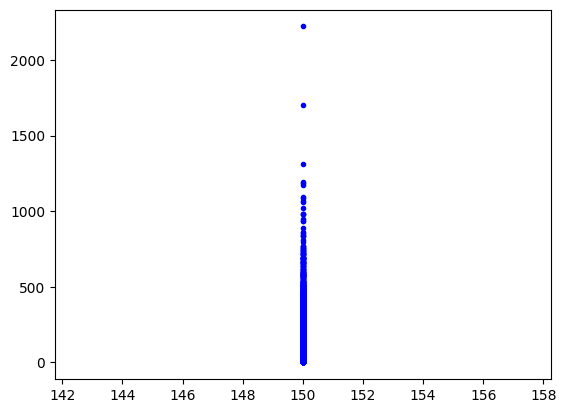

In [62]:
plt.plot(spot_paths[:, 0], pathwise_payoff, "b.")